# Scalability Experiments

## Setup

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import pandas as pd 
import time
import seaborn as sns
import matplotlib.pyplot as plt

from Code.training import compute_embedding
import Data.datasets as datasets

%matplotlib inline

import wandb
wandb.init(mode="disabled")

sns.set_theme(context="paper", style="ticks",
              rc={"axes.spines.right": False,
                  "axes.spines.top": False},
              font_scale=3,
              )
output_path = "Output/Scalability/"
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [2]:
# Configuration
dataset_config = {"ndim": 2,
                  "variance": 0.0675,
                  "seed": 420,
                  "noise": "uniform"}
dataset_generator = datasets.str_to_data("random")

# Method
method_name = "TOPO"
training_config = {
    'num_epochs': 100,
    'learning_rate': 0.01
}
random_state = 42

## Embeddings

In [3]:
if os.path.isfile(os.path.join(output_path, "scalability_results.csv")):
    results = pd.read_csv(os.path.join(output_path, "scalability_results.csv"))
else:
    data_sizes = [100, 1000, 10000, 100000]
    loss_configs = pd.DataFrame(
        columns=['loss', 'sampling', 'sampling_frac', 'sampling_rep'])

    loss_configs = loss_configs.append({'loss': 'one_circle',
                                        'sampling': False,
                                        'sampling_frac': 1,
                                        'sampling_rep': 1}, ignore_index=True)

    for n in data_sizes:
        data, labels = dataset_generator(n=n, **dataset_config)

        for i, row in loss_configs.iterrows():
            loss = {row.loss: {'sampling': row.sampling,
                               'sampling_frac': row.sampling_frac,
                               'sampling_rep': row.sampling_rep}}
            start = time.time()
            Y, _ = compute_embedding(data=data,
                                     loss_config=loss,
                                     training_config=training_config,
                                     method_name=method_name,
                                     method_config={},
                                     random_state=random_state,
                                     topo_weight=1)
            embedding_time = time.time() - start

            res = row.copy()
            res['n'] = n
            res['runtime'] = embedding_time
            results = results.append(res, ignore_index=True)
            
    results.to_csv(os.path.join(output_path, "scalability_results.csv"))


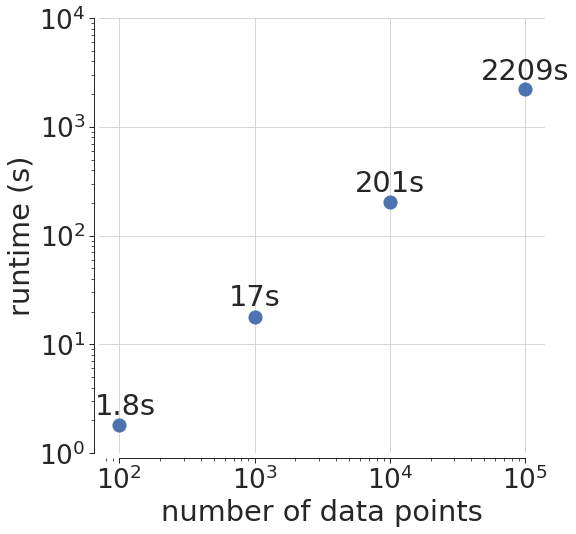

In [4]:
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=results.loc[(results.loss == "one_circle") & (results.sampling == False)],
                     x='n',
                     y='runtime',
                     s=200, linewidth=0,
                     color='b')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1, 1e4))

ax.set_xlabel('number of data points')
ax.set_ylabel('runtime (s)')
sns.despine(trim=True, offset=5)
ax.grid(True, which='major')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        tt = str(int(point['val']))+ "s" if point['val'] > 10 else f"{point['val']:.1f}s"
        ax.text(point['x']+10, point['y']+2*point['x']/1000, tt, verticalalignment='bottom', horizontalalignment='center')

label_point(results.loc[(results.loss == "one_circle") & (results.sampling == False)].n,
            results.loc[(results.loss == "one_circle") & (results.sampling == False)].runtime,
            results.loc[(results.loss == "one_circle") & (results.sampling == False)].runtime, 
            plt.gca())

plt.savefig(os.path.join(output_path, "runtime_log_log.png"), dpi=200, bbox_inches='tight')
